# Genome Assembly 3-2
**Assembling Fungal Genomes : Short Reads vs. Long Reads**

Fungal genomes are considerably larger and more complex than bacterial genomes. Unlike bacteria, which typically contain a single circular chromosome with relatively compact architecture, fungi often possess multiple chromosomes, high repeat content, heterozygosity, and substantial structural variation. These features make fungal genome assembly significantly more challenging and require strategies tailored for eukaryotic complexity. Although some assembly tools and workflows overlap with those used for bacteria, fungal genomes demand additional considerations—such as handling long repetitive regions, transposable elements, genome mosaics, and chromosome-level scaffolding. When only Illumina short reads are available, SPAdes can still be used to assemble fungal genomes, but with important modifications and realistic expectations. SPAdes performs reasonably well for moderate-sized fungal genomes, yet assemblies will typically be fragmented due to repeat structures and heterozygosity. Careful selection of k-mer sizes, use of the --careful mode, and strict quality filtering help improve contiguity, but short-read assemblies rarely achieve chromosome-level continuity. For long-read data, tools such as Flye are strongly recommended. Flye excels at assembling repetitive and structurally complex fungal genomes using Nanopore or PacBio reads and frequently produces near–chromosome-level assemblies that outperform short-read assemblers by orders of magnitude. In practice, hybrid strategies—long-read assembly with Flye followed by Illumina polishing—provide the most accurate and complete fungal genome reconstructions.

##Install dependencies and tools##

**Install miniconda**

In [1]:
# @title
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge

--2025-11-17 20:08:09--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157891003 (151M) [application/octet-stream]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 150.58M  61.6MB/s    in 2.4s    

2025-11-17 20:08:11 (61.6 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [157891003/157891003]

PREFIX=/usr/local
Unpacking bootstrapper...
Unpacking payload...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please

In [2]:
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
!conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r


**Install fastqc, trim_galore, spades, Nanoplot, filtlong**

In [3]:
# @title
!conda install -c conda-forge ncbi-datasets-cli -y
!conda install bioconda::nanoplot -y
!conda install -c bioconda filtlong -y
!conda install bioconda::flye -y
!conda install -c bioconda quast -y
!conda install bioconda::pysradb -y

Jupyter detected...
2 channel Terms of Service accepted
Retrieving notices: - \ | / done
Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ncbi-datasets-cli


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.11.12 |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.11.12         |     pyhd8ed1ab_0         153 KB  conda-forge
    ncbi-datasets-cli-18.9.0   |       ha770c72_0        16.1 MB  conda-forge
    openssl-3.6.0              |       h26f9b46_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        19.4 MB

The following NEW packages will be INSTALLED:

  ncbi-datasets-cli  conda-forge/linux-64::ncbi-dataset

In [4]:
!apt-get update -qq
!apt-get install -y fastqc

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core default-jre default-jre-headless fonts-dejavu-core
  fonts-dejavu-extra gsettings-desktop-schemas libapache-pom-java
  libargs4j-java libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data libatspi2.0-0
  libcommons-compress-java libcommons-io-java libcommons-jexl2-java
  libcommons-lang3-java libcommons-logging-java libcommons-math3-java
  libcommons-parent-java libfindbin-libs-perl libhtsjdk-java libjbzip2-java
  libjson-simple-java libngs-java libngs-sdk-dev libngs-sdk2 libsis-base-java
  libsis-base-jni libsis-jhdf5-java libsis-jhdf5-jni libsnappy-java
  libsnappy-jni libxcomposite1 libxtst6 libxxf

Install sra-toolkit that will allow us to fetch raw squeneces from the SRA-NCBI database

In [5]:
!apt-get update -qq
!apt-get install -y -qq sra-toolkit


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Preconfiguring packages ...
Selecting previously unselected package menu.
(Reading database ... 122733 files and directories currently installed.)
Preparing to unpack .../0-menu_2.1.47ubuntu4_amd64.deb ...
Unpacking menu (2.1.47ubuntu4) ...
Selecting previously unselected package blends-common.
Preparing to unpack .../1-blends-common_0.7.4ubuntu1_all.deb ...
Unpacking blends-common (0.7.4ubuntu1) ...
Selecting previously unselected package libkdf5-2.
Preparing to unpack .../2-libkdf5-2_2.11.2+dfsg-4build2_amd64.deb ...
Unpacking libkdf5-2 (2.11.2+dfsg-4build2) ...
Selecting previously unselected package libncbi-vdb2.
Preparing to unpack .../3-libncbi-vdb2_2.11.2+dfsg-4build2_amd64.deb ...
Unpacking libncbi-vdb2 (2.11.2+dfsg-4build2) ...
Selecting previously unselected package libncbi-wvdb2.
Preparing

We will fetch illumina and nanopore reads of Fusarium oxysporum f.sp. niveum from the SRA-NCBI database
https://www.ncbi.nlm.nih.gov/sra?term=SAMN16727279

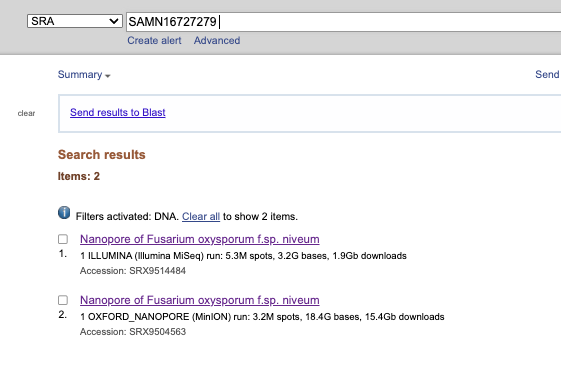

In [6]:
!fastq-dump --version
#get Illumina
!fasterq-dump SRR13066517 -e 4 -p


"fastq-dump" version 2.11.3

join   :|  0.00% 0.01% 0.02% 0.03% 0.04% 0.05% 0.06% 0.07% 0.08% 0.09% 0.10% 0.11% 0.12% 0.13% 0.14% 0.15% 0.16% 0.17% 0.18% 0.19% 0.20% 0.21% 0.22% 0.23% 0.24% 0.25% 0.26% 0.27% 0.28% 0.29% 0.30% 0.31% 0.32% 0.33% 0.34% 0.35% 0.36% 0.37% 0.38% 0.39% 0.40% 0.41% 0.42% 0.43% 0.44% 0.45% 0.46% 0.47% 0.48% 0.49% 0.50% 0.51% 0.52% 0.53% 0.54% 0.55% 0.56% 0.57% 0.58% 0.59% 0.60% 0.61% 0.62% 0.63% 0.64% 0.65% 0.66% 0.67% 0.68% 0.69% 0.70% 0.71% 0.72% 0.73% 0.74% 0.75% 0.76% 0.77% 0.78% 0.79%

In [7]:
#Get nanopore
!fasterq-dump SRR13055260

spots read      : 3,155,447
reads read      : 3,155,447
reads written   : 3,155,447


Run quality control for the illumina reads

In [8]:
!fastqc SRR13066517_1.fastq
!fastqc SRR13066517_2.fastq

Started analysis of SRR13066517_1.fastq
Approx 5% complete for SRR13066517_1.fastq
Approx 10% complete for SRR13066517_1.fastq
Approx 15% complete for SRR13066517_1.fastq
Approx 20% complete for SRR13066517_1.fastq
Approx 25% complete for SRR13066517_1.fastq
Approx 30% complete for SRR13066517_1.fastq
Approx 35% complete for SRR13066517_1.fastq
Approx 40% complete for SRR13066517_1.fastq
Approx 45% complete for SRR13066517_1.fastq
Approx 50% complete for SRR13066517_1.fastq
Approx 55% complete for SRR13066517_1.fastq
Approx 60% complete for SRR13066517_1.fastq
Approx 65% complete for SRR13066517_1.fastq
Approx 70% complete for SRR13066517_1.fastq
Approx 75% complete for SRR13066517_1.fastq
Approx 80% complete for SRR13066517_1.fastq
Approx 85% complete for SRR13066517_1.fastq
Approx 90% complete for SRR13066517_1.fastq
Approx 95% complete for SRR13066517_1.fastq
Analysis complete for SRR13066517_1.fastq
Started analysis of SRR13066517_2.fastq
Approx 5% complete for SRR13066517_2.fastq


In [ ]:
import os
from IPython.core.display import display, HTML

# Ask the user for the file name they want to display
file_name = input("Enter the name of the HTML file you want to display (include .html extension): ")

# Check if the file exists
if os.path.exists(file_name):
    # Open and read the HTML file
    with open(file_name, 'r') as file:
        html_content = file.read()
        display(HTML(html_content))  # Display the HTML content
else:
    print(f"File '{file_name}' not found. Please ensure the file exists in the current directory.")


In [ ]:
%%bash
# 1️⃣  Install micromamba (lightweight conda)
wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null

# 2️⃣  Initialize the shell
eval "$(./bin/micromamba shell hook -s bash)"

# 3️⃣  Create an isolated environment (Python 3.12 avoids cutadapt conflict)
micromamba create -y -n tg -c conda-forge -c bioconda python=3.12 trim-galore cutadapt fastqc

# 4️⃣  Confirm installation
micromamba run -n tg trim_galore --version
micromamba run -n tg cutadapt --version


**Filter and Clip Sequences**

Filter and trim sequences based on a Phred score greater than 20, removing adapters and considering nucleotide composition.

In [ ]:
%%bash
# Activate micromamba shell
eval "$(./bin/micromamba shell hook -s bash)"
micromamba run -n tg trim_galore --paired --clip_R1 15 --clip_R2 15 --three_prime_clip_R1 10 --three_prime_clip_R2 10 --fastqc SRR13066517_1.fastq SRR13066517_2.fastq


In [ ]:
import os
from IPython.core.display import display, HTML

# Ask the user for the file name they want to display
file_name = input("Enter the name of the HTML file you want to display (include .html extension): ")

# Check if the file exists
if os.path.exists(file_name):
    # Open and read the HTML file
    with open(file_name, 'r') as file:
        html_content = file.read()
        display(HTML(html_content))  # Display the HTML content
else:
    print(f"File '{file_name}' not found. Please ensure the file exists in the current directory.")

**Run the Illumina assembler SPAdes using the --isolate option. This option is designed for cases where the reads originate from a single, pure isolate..**

Get Spades

In [ ]:
#2022-10-21 Steven Tang
#!wget http://cab.spbu.ru/files/release3.9.0/SPAdes-3.9.0-Linux.tar.gz
#!tar -xzf SPAdes-3.9.0-Linux.tar.gz

#2023-09-15 Renald Legaspi
#Updated: Spades3.9 to 3.15 since that version no longer runs on colab because a different version of python is being implemented.
#Fix: No longer installs the Linux tarfile due to segment fault issue. Spades is now being compiled from source.
# !wget http://cab.spbu.ru/files/release3.15.5/SPAdes-3.15.5.tar.gz
# !tar -xzf SPAdes-3.15.5.tar.gz
# !cd SPAdes-3.15.5
# !./SPAdes-3.15.5/spades_compile.sh

#2023-09-18 Steven Tang
#Fix: Use precompiled SPAdes that works with Colab
!wget https://github.com/steventango/colab-spades/releases/download/v3.15.5/SPAdes-3.15.5-Colab.tar.gz
!tar -xzf SPAdes-3.15.5-Colab.tar.gz


from datetime import datetime
from google.colab import files
from pathlib import Path
import subprocess

Run Spades

In [ ]:
# Tries to reduce the number of mismatches and short indels.
# Also runs MismatchCorrector: A post processing tool that uses BWA tool.
# Recommended mostly for small and/or low complexity genome.

#2022-10-21 Steven Tang
#careful_mode = True

#2023-09-15 Renald Legaspi
#Updated: Careful mode may cause the spades.py to crash due to insufficient RAM
careful_mode = False

#2023-09-15 Renald Legaspi
#Colab no longer implements python2; thus 'python /path/spades.py' is used instead of 'python2 /path/spades.py'
pe1_filename = "SRR13066517_1_val_1.fq.gz"
pe2_filename = "SRR13066517_2_val_2.fq.gz"

output_directory = f"{Path(pe1_filename).stem}_{Path(pe2_filename).stem}_{datetime.now().isoformat()}"

process = subprocess.run(
    f'python ./bin/spades.py --isolate -1 SRR13066517_1_val_1.fq.gz -2 SRR13066517_2_val_2.fq.gz -o spades_output',
    capture_output=True,
    text=True,
    shell=True
)

#print(process.stdout)
#print(process.stderr)

Your results are in spades_output. We will compare the results with long reads assembly

#Long Reads assembly

Run Quality Control for Long Reads

NanoPlot is a tool designed for quality control of Oxford Nanopore long reads. However, it can also be adapted for use with PacBio HiFi long reads to perform simple QC analysis.

In [ ]:
!NanoPlot --fastq SRR13055260 -o nanoplot_output

Filter reads shorter than 1 Kb

In [ ]:
!filtlong --min_length 1000 --keep_percent 90 SRR13055260 | gzip > filtered_SRR13055260.fq


Scoring long reads
  213,987 reads (1,244,010,289 bp)

Filtering long reads
  target: 1,119,609,260 bp
  keeping 1,119,611,298 bp

Outputting passed long reads



Run QC again and check results

In [ ]:
!NanoPlot --fastq filtered_SRR13055260.fq -o filtered_nanoplot_output

Run Long-Read Assembler - Flye

Run the long-read assembler Flye using only a subset of reads that provide 50x coverage of the genome. This approach helps conserve computational resources. The coverage can be increased as needed based on specific requirements.

Install Flye

In [ ]:
!apt-get update
!apt-get install -y build-essential python3-dev zlib1g-dev libbz2-dev liblzma-dev git

# Download Flye source
!git clone https://github.com/fenderglass/Flye.git
%cd Flye

# Build Flye
!make

# Flye executable will be created in bin/
%cd bin
!chmod +x flye

# Add Flye to PATH
import os
os.environ["PATH"] += ":/content/Flye/bin"

In [ ]:
!flye --nano-raw /content/filtered_SRR13055260.fq -o /content/flye_results

#Assembly stats and comparisions

Compare Both Assemblies Using quast

Evaluate metrics such as the number of contigs, genome size, N50.

In [ ]:
!mkdir assemblies/
!cp spades_output/contigs.fasta assemblies/spades_contigs.fasta
!cp flye_results/assembly.fasta assemblies/flye_contigs.fasta
!quast assemblies/spades_contigs.fasta assemblies/flye_contigs.fasta